In [2]:
%matplotlib inline


# Comparing different clustering algorithms on toy datasets


This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.



In [42]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as color
import hdbscan

from sklearn.metrics import homogeneity_score,homogeneity_completeness_v_measure
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

Automatically created module for IPython interactive environment


In [4]:
from scipy.io import loadmat

This is the plotting for the larger images

/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceW

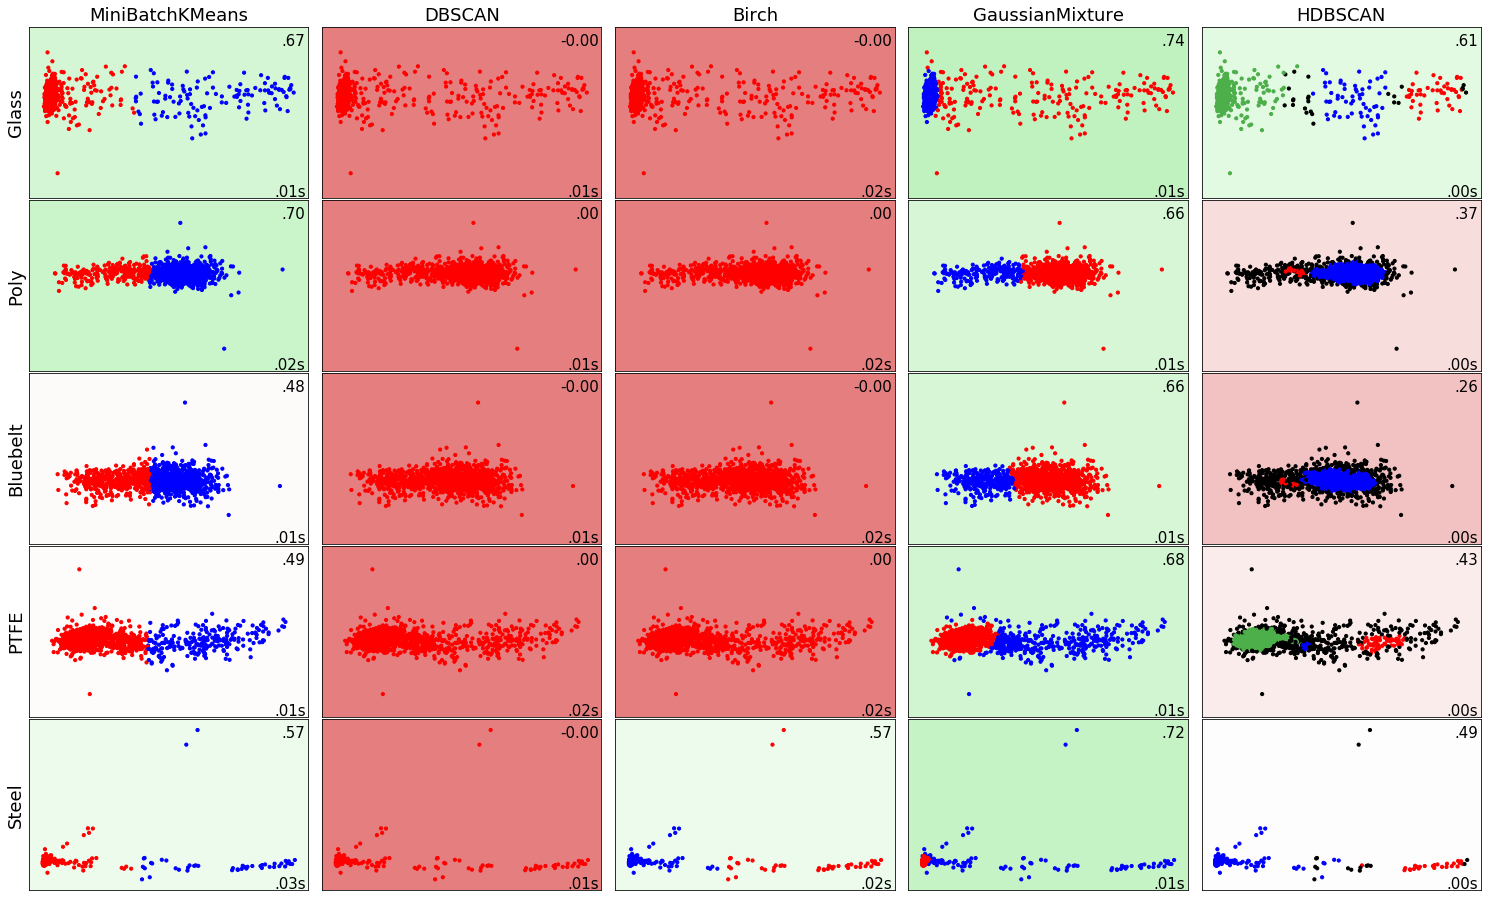

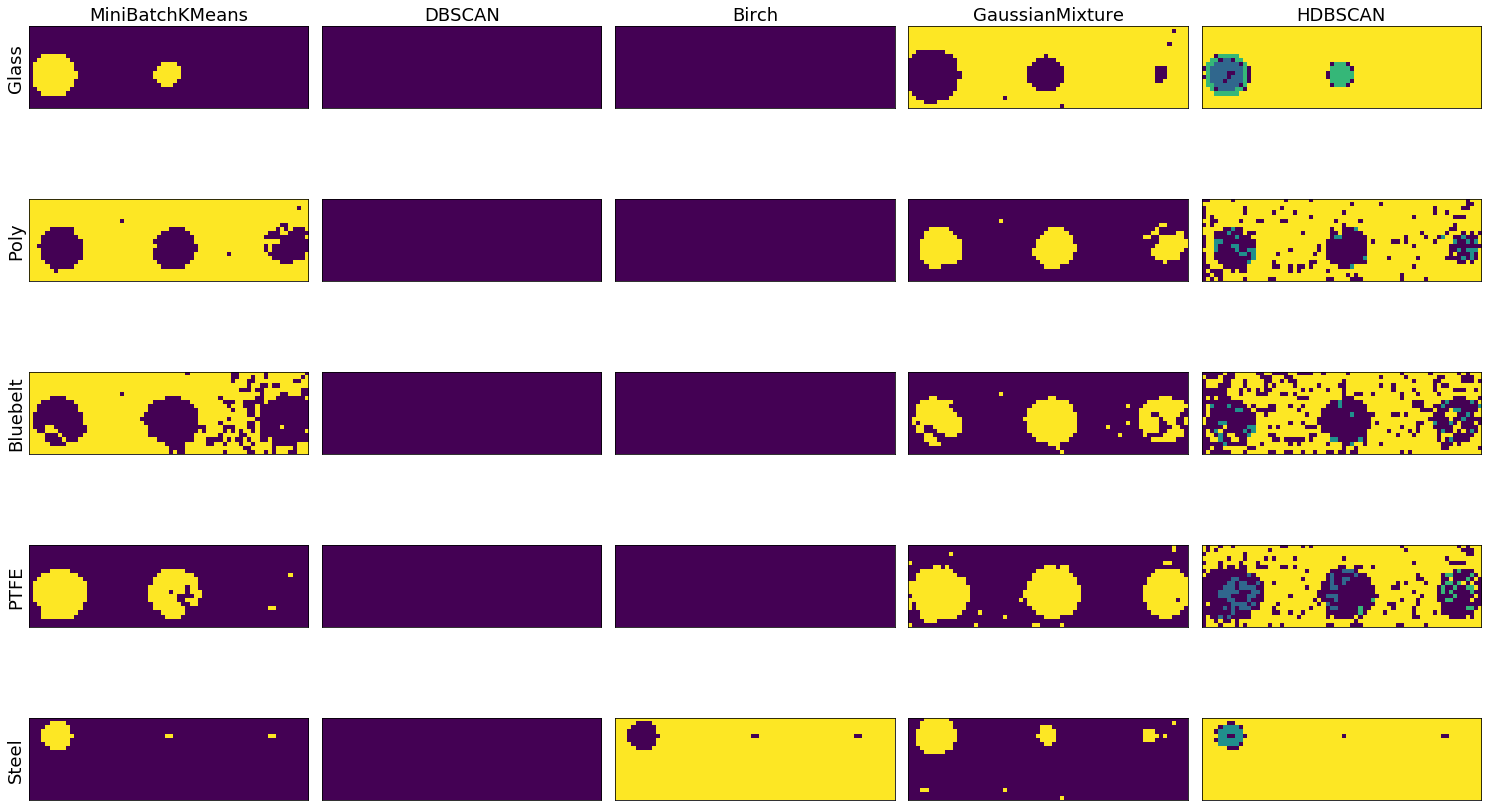

In [40]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
# noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
#                                       noise=.05)
# noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
# varied = datasets.make_blobs(n_samples=n_samples,
#                              cluster_std=[1.0, 2.5, 0.5],
#                              random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(1,figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plt.figure(2,figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)


plot_num = 1

# default_base = {'quantile': .3,
#                 'eps': .3,
#                 'damping': .9,
#                 'preference': -200,
#                 'n_neighbors': 10,
#                 'n_clusters': 2}

default_base = {'quantile': .3,
                'eps': .5,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 2,
                'n_clusters': 2}
# datasets2 = [
#     (aniso, {'eps': .15, 'n_neighbors': 2})]

datasets2 = (('2glass','Glass'),('2pp','Poly'),('2bb','Bluebelt'),('2ptfe','PTFE'),('2steel','Steel'
            ))
                                                                          
# This dictionary defines the colormap
cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'green': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
P = color.LinearSegmentedColormap('GnRd', cdict)

homo, comp, vs, idata, ialgo = [],[],[],[],[]

# for i_dataset, (dataset, algo_params) in enumerate(datasets2):
for i_dataset, (dataset,dat_name) in enumerate(datasets2):

    # update parameters with dataset-specific values
    params = default_base.copy()
#     params.update(algo_params)

    #X, y = dataset
    
    X = loadmat(dataset)['Z']
    label_true = loadmat(dataset+'_mask')['BW']
    
#     xx,yy = np.meshgrid(range(68),range(20))
    
#     x = np.reshape(xx, (20*68,1), order="F")
#     y = np.reshape(yy, (20*68,1), order="F")
    
#     X = np.concatenate((X,x,y),axis = 1)

#     # normalize dataset for easier parameter selection
#     X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        #('MeanShift', ms),
        #('SpectralClustering', spectral),
        #('Ward', ward),
        #('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('HDBSCAN', hdbscan.HDBSCAN)
    )

    for i_algorithm, (name, algorithm) in enumerate(clustering_algorithms):
        #plt.figure()
        #plt.axis('equal')
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            if hasattr(algorithm, 'condensed_tree_'):
                pass
            else:
                algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        elif hasattr(algorithm, 'condensed_tree_'):
            y_pred = algorithm(20).fit_predict(X)
        else:
            y_pred = algorithm.predict(X)
            
        plt.figure(1) 
        homo1,comp1,vs1 = homogeneity_completeness_v_measure(label_true.squeeze(), y_pred)

        plt.rcParams['axes.facecolor'] = P(1 - vs1,alpha=0.5)

        plt.subplot(len(datasets2), len(clustering_algorithms), plot_num)
#         plt.subplot(121)
        if i_dataset == 0:
            plt.title(name, size=18)
        if i_algorithm == 0:
            plt.ylabel(dat_name, size=18)
            
#         if vs1 > 0.5:
#             plt.rcParams['axes.facecolor'] = (0,vs1 - 0.49,0)
#         else:
#             plt.rcParams['axes.facecolor'] = (0.5 - vs1,0,0)    


        colors = np.array(list(islice(cycle(['r','b', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:,1], s=10, color=colors[y_pred])
        r = np.reshape(y_pred, (20,68), order="F")

#         plt.xlim(-2.5, 2.5)
#         plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plt.text(.99, .89, ('%.2f' % vs1).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        
        plt.figure(2)
            
        plt.subplot(len(datasets2), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
#         plt.subplot(122)
        plt.imshow(r)
        plt.xticks([])
        plt.yticks([])        
        if i_algorithm == 0:
            plt.ylabel(dat_name, size=18)                
        homo.append(homo1)
        comp.append(comp1)
        vs.append(vs1)
        
        idata.append(i_dataset)
        ialgo.append(i_algorithm)
        
        plot_num += 1

plt.show()

/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceW

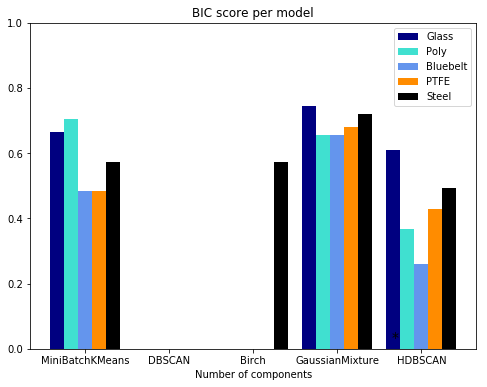

In [39]:
np.random.seed(0)
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

default_base = {'quantile': .3,
                'eps': .5,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 2,
                'n_clusters': 2}

# datasets2 = (('2glass','Glass'),('2pp','Poly'),('2bb','Bluebelt'),('2ptfe','PTFE'),('2steel','Steel'
#             ))
datasets2 = (('glass','Glass'),('pp','Poly'),('bb','Bluebelt'),('ptfe','PTFE'),('steel','Steel'
            ))

homo, comp, vs, idata, ialgo = [],[],[],[],[]

for i_dataset, (dataset,dat_name) in enumerate(datasets2):

    # update parameters with dataset-specific values
    params = default_base.copy()
#   params.update(algo_params)
    
    X = loadmat('2'+dataset)['Z']
    label_true = loadmat('2'+dataset+'_mask')['BW']
    
    xx,yy = np.meshgrid(range(68),range(20))
    
#     x = np.reshape(xx, (20*68,1), order="F")
#     y = np.reshape(yy, (20*68,1), order="F")
# #     X = np.reshape(X, (20*68,1), order="F")    
# #     x = np.reshape(xx, (20*68), order="F")
# #     y = np.reshape(yy, (20*68), order="F")
    
#     X = np.concatenate((X,x,y),axis = 1)
#     X = np.concatenate((X,x,y))
    
    # normalize dataset for easier parameter selection
#     X = StandardScaler().fit_transform(X)    
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        #('MeanShift', ms),
        #('SpectralClustering', spectral),
        #('Ward', ward),
        #('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('HDBSCAN', hdbscan.HDBSCAN)
    )

    for i_algorithm, (name, algorithm) in enumerate(clustering_algorithms):
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            if hasattr(algorithm, 'condensed_tree_'):
                pass
            else:
                algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        elif hasattr(algorithm, 'condensed_tree_'):
            y_pred = algorithm(20).fit_predict(X)
        else:
            y_pred = algorithm.predict(X)
            
        homo1,comp1,vs1 = homogeneity_completeness_v_measure(label_true.squeeze(), y_pred)

        homo.append(homo1)
        comp.append(comp1)
        vs.append(vs1)
        
        idata.append(i_dataset)
        ialgo.append(i_algorithm)

vs = np.asarray(vs)
bars = []
n_components_range = range(len(clustering_algorithms))
cv_types = [item[1] for item in datasets2]


color_iter = cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange','k'])
# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(1, 1, 1)

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .166 * (i - 2)
    bars.append(plt.bar(xpos, vs[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.166, color=color))
plt.xticks(n_components_range,[item[0] for item in clustering_algorithms])
plt.xticks()
plt.ylim([0, 1])
plt.title('BIC score per model')
xpos = np.mod(vs.argmax(), len(n_components_range)) + .65 +\
    .16 * np.floor(vs.argmax() / len(n_components_range))
plt.text(xpos, vs.min() * 0.97 + .03 * vs.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)     

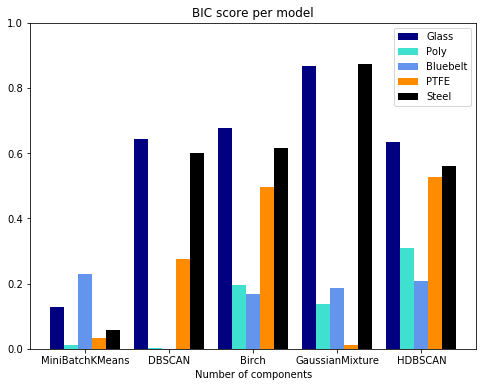

In [21]:
from cycler import cycler

np.random.seed(0)
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

default_base = {'quantile': .3,
                'eps': .5,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 2,
                'n_clusters': 2}

# datasets2 = (('2glass','Glass'),('2pp','Poly'),('2bb','Bluebelt'),('2ptfe','PTFE'),('2steel','Steel'
#             ))
datasets2 = (('glass','Glass'),('pp','Poly'),('bb','Bluebelt'),('ptfe','PTFE'),('steel','Steel'
            ))

homo, comp, vs, idata, ialgo = [],[],[],[],[]

for i_dataset, (dataset,dat_name) in enumerate(datasets2):

    # update parameters with dataset-specific values
    params = default_base.copy()
#   params.update(algo_params)
    
    X = loadmat('all'+dataset)['Z'][:,0]
    label_true = loadmat('2'+dataset+'_mask')['BW']
    
    xx,yy = np.meshgrid(range(68),range(20))
    
    x = np.reshape(xx, (20*68,1), order="F")
    y = np.reshape(yy, (20*68,1), order="F")
    X = np.reshape(X, (20*68,1), order="F")    
#     x = np.reshape(xx, (20*68), order="F")
#     y = np.reshape(yy, (20*68), order="F")
    
    X = np.concatenate((X,x,y),axis = 1)
#     X = np.concatenate((X,x,y))
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)    
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        #('MeanShift', ms),
        #('SpectralClustering', spectral),
        #('Ward', ward),
        #('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('HDBSCAN', hdbscan.HDBSCAN)
    )

    for i_algorithm, (name, algorithm) in enumerate(clustering_algorithms):
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            if hasattr(algorithm, 'condensed_tree_'):
                pass
            else:
                algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        elif hasattr(algorithm, 'condensed_tree_'):
            y_pred = algorithm(20).fit_predict(X)
        else:
            y_pred = algorithm.predict(X)
            
        homo1,comp1,vs1 = homogeneity_completeness_v_measure(label_true.squeeze(), y_pred)

        homo.append(homo1)
        comp.append(comp1)
        vs.append(vs1)
        
        idata.append(i_dataset)
        ialgo.append(i_algorithm)

vs = np.asarray(vs)
bars = []
n_components_range = range(len(clustering_algorithms))
cv_types = [item[1] for item in datasets2]


color_iter = cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange','k'])
# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(1, 1, 1)

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .166 * (i - 2)
    bars.append(plt.bar(xpos, vs[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.166, color=color))
plt.xticks(n_components_range,[item[0] for item in clustering_algorithms])
plt.xticks()
plt.ylim([0, 1])
plt.title('BIC score per model')
xpos = np.mod(vs.argmax(), len(n_components_range)) + .65 +\
    .16 * np.floor(vs.argmax() / len(n_components_range))
plt.text(xpos, vs.min() * 0.97 + .03 * vs.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)       

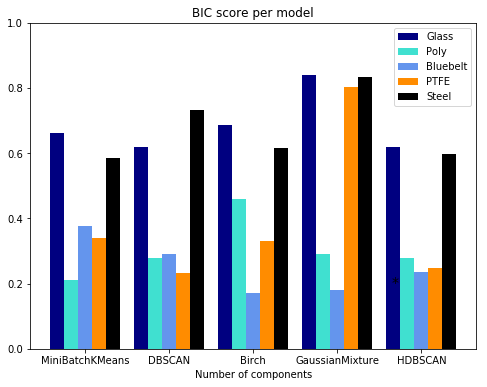

In [38]:
from cycler import cycler

np.random.seed(0)
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

default_base = {'quantile': .3,
                'eps': .5,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 2,
                'n_clusters': 2}

# datasets2 = (('2glass','Glass'),('2pp','Poly'),('2bb','Bluebelt'),('2ptfe','PTFE'),('2steel','Steel'
#             ))
datasets2 = (('glass','Glass'),('pp','Poly'),('bb','Bluebelt'),('ptfe','PTFE'),('steel','Steel'
            ))

homo, comp, vs, idata, ialgo = [],[],[],[],[]

for i_dataset, (dataset,dat_name) in enumerate(datasets2):

    # update parameters with dataset-specific values
    params = default_base.copy()
#   params.update(algo_params)
    
    X = loadmat('all'+dataset)['Z'][:,1:]
    X = np.column_stack((np.sum(X[:,1:3],1),np.sum(X[:,4:],1)))
    label_true = loadmat('2'+dataset+'_mask')['BW']
    
    xx,yy = np.meshgrid(range(68),range(20))
    
    x = np.reshape(xx, (20*68,1), order="F")
    y = np.reshape(yy, (20*68,1), order="F")
#     X = np.reshape(X, (20*68,1), order="F")    
#     x = np.reshape(xx, (20*68), order="F")
#     y = np.reshape(yy, (20*68), order="F")
    
    X = np.concatenate((X,x,y),axis = 1)
#     X = np.concatenate((X,x,y))
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)    
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        #('MeanShift', ms),
        #('SpectralClustering', spectral),
        #('Ward', ward),
        #('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('HDBSCAN', hdbscan.HDBSCAN)
    )

    for i_algorithm, (name, algorithm) in enumerate(clustering_algorithms):
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            if hasattr(algorithm, 'condensed_tree_'):
                pass
            else:
                algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        elif hasattr(algorithm, 'condensed_tree_'):
            y_pred = algorithm(20).fit_predict(X)
        else:
            y_pred = algorithm.predict(X)
            
        homo1,comp1,vs1 = homogeneity_completeness_v_measure(label_true.squeeze(), y_pred)

        homo.append(homo1)
        comp.append(comp1)
        vs.append(vs1)
        
        idata.append(i_dataset)
        ialgo.append(i_algorithm)

vs = np.asarray(vs)
bars = []
n_components_range = range(len(clustering_algorithms))
cv_types = [item[1] for item in datasets2]


color_iter = cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange','k'])
# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(1, 1, 1)

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .166 * (i - 2)
    bars.append(plt.bar(xpos, vs[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.166, color=color))
plt.xticks(n_components_range,[item[0] for item in clustering_algorithms])
plt.xticks()
plt.ylim([0, 1])
plt.title('BIC score per model')
xpos = np.mod(vs.argmax(), len(n_components_range)) + .65 +\
    .16 * np.floor(vs.argmax() / len(n_components_range))
plt.text(xpos, vs.min() * 0.97 + .03 * vs.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)   

In [69]:
def plot_results(sc=0,sr=0,sv=1,mode=[],w_positions=False,scale=False,default_base=
                 {'quantile': .3,'eps': .5,'damping': .9,'preference': -200,'n_neighbors': 2,
                    'n_clusters': 2}):
    
    '''
    sc: bool
    show clusters plot
    sr: bool
    show reconstruction plot
    sv: bool
    show vscores
    mode: string
    [] = pca, 'all'= all, 'de' = dual energy,'se' = integrating detector 
    W_position: bool
    Add positions to the vectors
    scale: bool
    Rescale the input, this is important if you add the position data
    default_base: dict
    Parameters for the clustering algorithms
    '''

    np.random.seed(10)


    # ============
    # Set up cluster parameters
    # ============
    if sc:
        plt.figure(1,figsize=(9 * 2 + 3, 12.5))
        plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                            hspace=.01)
    if sr:
        plt.figure(2,figsize=(9 * 2 + 3, 12.5))
        plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                            hspace=.01)


    plot_num = 1


    # This dictionary defines the colormap
    cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                      (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                      (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

            'green': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                      (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                      (1.0, 0.0, 0.0)),  # no green at 1

            'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                      (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                      (1.0, 0.0, 0.0))   # no blue at 1
           }

    # Create the colormap using the dictionary
    P = color.LinearSegmentedColormap('GnRd', cdict)

    homo, comp, vs, idata, ialgo = [],[],[],[],[]
    
    datasets2 = (('glass','Glass'),('pp','Poly'),('bb','Bluebelt'),('ptfe','PTFE'),('steel','Steel'
            ))

    for i_dataset, (dataset,dat_name) in enumerate(datasets2):

        # update parameters with dataset-specific values
        params = default_base.copy()
    #   params.update(algo_params)


        if mode == 'de':
            X = loadmat('all'+dataset)['Z'][:,1:]
            X = np.column_stack((np.sum(X[:,1:3],1),np.sum(X[:,4:],1)))
        elif mode == 'se':
            X = loadmat('all'+dataset)['Z'][:,0]
            X = np.reshape(X, (20*68,1), order="F") 
        elif mode == 'all':
            X = loadmat('all'+dataset)['Z'][:,1:]
        else:
            X = loadmat('2'+dataset)['Z']

        label_true = loadmat('2'+dataset+'_mask')['BW']

        if w_positions:
            xx,yy = np.meshgrid(range(68),range(20))        
            x = np.reshape(xx, (20*68,1), order="F")
            y = np.reshape(yy, (20*68,1), order="F")
            X = np.concatenate((X,x,y),axis = 1)

        if scale:
            X = StandardScaler().fit_transform(X)    

        # estimate bandwidth for mean shift
        bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=params['n_neighbors'], include_self=False)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)

        # ============
        # Create cluster objects
        # ============
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
#         ward = cluster.AgglomerativeClustering(
#             n_clusters=params['n_clusters'], linkage='ward',
#             connectivity=connectivity)
#         spectral = cluster.SpectralClustering(
#             n_clusters=params['n_clusters'], eigen_solver='arpack',
#             affinity="nearest_neighbors")
        dbscan = cluster.DBSCAN(eps=params['eps'])
#         affinity_propagation = cluster.AffinityPropagation(
#             damping=params['damping'], preference=params['preference'])
#         average_linkage = cluster.AgglomerativeClustering(
#             linkage="average", affinity="cityblock",
#             n_clusters=params['n_clusters'], connectivity=connectivity)
        birch = cluster.Birch(n_clusters=params['n_clusters'])
        gmm = mixture.GaussianMixture(
            n_components=params['n_clusters'], covariance_type='full')

        clustering_algorithms = (
            ('MiniBatchKMeans', two_means),
            #('AffinityPropagation', affinity_propagation),
            #('MeanShift', ms),
            #('SpectralClustering', spectral),
            #('Ward', ward),
            #('AgglomerativeClustering', average_linkage),
            ('DBSCAN', dbscan),
            ('Birch', birch),
            ('GaussianMixture', gmm),
            ('HDBSCAN', hdbscan.HDBSCAN)
        )

        for i_algorithm, (name, algorithm) in enumerate(clustering_algorithms):

            t0 = time.time()

            # catch warnings related to kneighbors_graph
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="the number of connected components of the " +
                    "connectivity matrix is [0-9]{1,2}" +
                    " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning)
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding" +
                    " may not work as expected.",
                    category=UserWarning)
                if hasattr(algorithm, 'condensed_tree_'):
                    pass
                else:
                    algorithm.fit(X)

            t1 = time.time()
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            elif hasattr(algorithm, 'condensed_tree_'):
                y_pred = algorithm(20).fit_predict(X)
            else:
                y_pred = algorithm.predict(X)
                
            homo1,comp1,vs1 = homogeneity_completeness_v_measure(label_true.squeeze(), y_pred)
            
            if sc:
                plt.figure(1)

                plt.rcParams['axes.facecolor'] = P(1 - vs1,alpha=0.5)

                plt.subplot(len(datasets2), len(clustering_algorithms), plot_num)
                if i_dataset == 0:
                    plt.title(name, size=18)
                if i_algorithm == 0:
                    plt.ylabel(dat_name, size=18)


                colors2 = np.array(list(islice(cycle(['r','b', '#4daf4a',
                                                     '#f781bf', '#a65628', '#984ea3',
                                                     '#999999', '#e41a1c', '#dede00']),
                                              int(max(y_pred) + 1))))
                
                # add black color for outliers (if any)
                colors2 = np.append(colors2, ["#000000"])
                plt.scatter(X[:, 0], X[:,1], s=10, color=colors2[y_pred])

                plt.xticks(())
                plt.yticks(())
                plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                         transform=plt.gca().transAxes, size=15,
                         horizontalalignment='right')
                plt.text(.99, .89, ('%.2f' % vs1).lstrip('0'),
                         transform=plt.gca().transAxes, size=15,
                         horizontalalignment='right')
            if sr:
                plt.figure(2)
                r = np.reshape(y_pred, (20,68), order="F")
                plt.subplot(len(datasets2), len(clustering_algorithms), plot_num)
                if i_dataset == 0:
                    plt.title(name, size=18)
                plt.imshow(r)
                plt.xticks([])
                plt.yticks([])        
                if i_algorithm == 0:
                    plt.ylabel(dat_name, size=18) 
                    
            homo.append(homo1)
            comp.append(comp1)
            vs.append(vs1)

            idata.append(i_dataset)
            ialgo.append(i_algorithm)

            plot_num += 1

    plt.show()
    
    if sv:
        
        vs = np.asarray(vs)
        bars = []
        n_components_range = range(len(clustering_algorithms))
        cv_types = [item[1] for item in datasets2]


        color_iter = cycle(['navy', 'turquoise', 'cornflowerblue',
                                      'darkorange','k'])
        # Plot the BIC scores
        plt.figure(figsize=(8, 6))
        spl = plt.subplot(1, 1, 1)

        for i, (cv_type, pcolor) in enumerate(zip(cv_types, color_iter)):
            xpos = np.array(n_components_range) + .166 * (i - 2)
            bars.append(plt.bar(xpos, vs[i * len(n_components_range):
                                          (i + 1) * len(n_components_range)],
                                width=.166, color=pcolor))
        plt.xticks(n_components_range,[item[0] for item in clustering_algorithms])
        plt.xticks()
        plt.ylim([0, 1])
        plt.title('V score per model')
        xpos = np.mod(vs.argmax(), len(n_components_range)) + .65 +\
            .16 * np.floor(vs.argmax() / len(n_components_range))
        plt.text(xpos, vs.min() * 0.97 + .03 * vs.max(), '*', fontsize=14)
        spl.set_xlabel('Number of components')
        spl.legend([b[0] for b in bars], cv_types)   

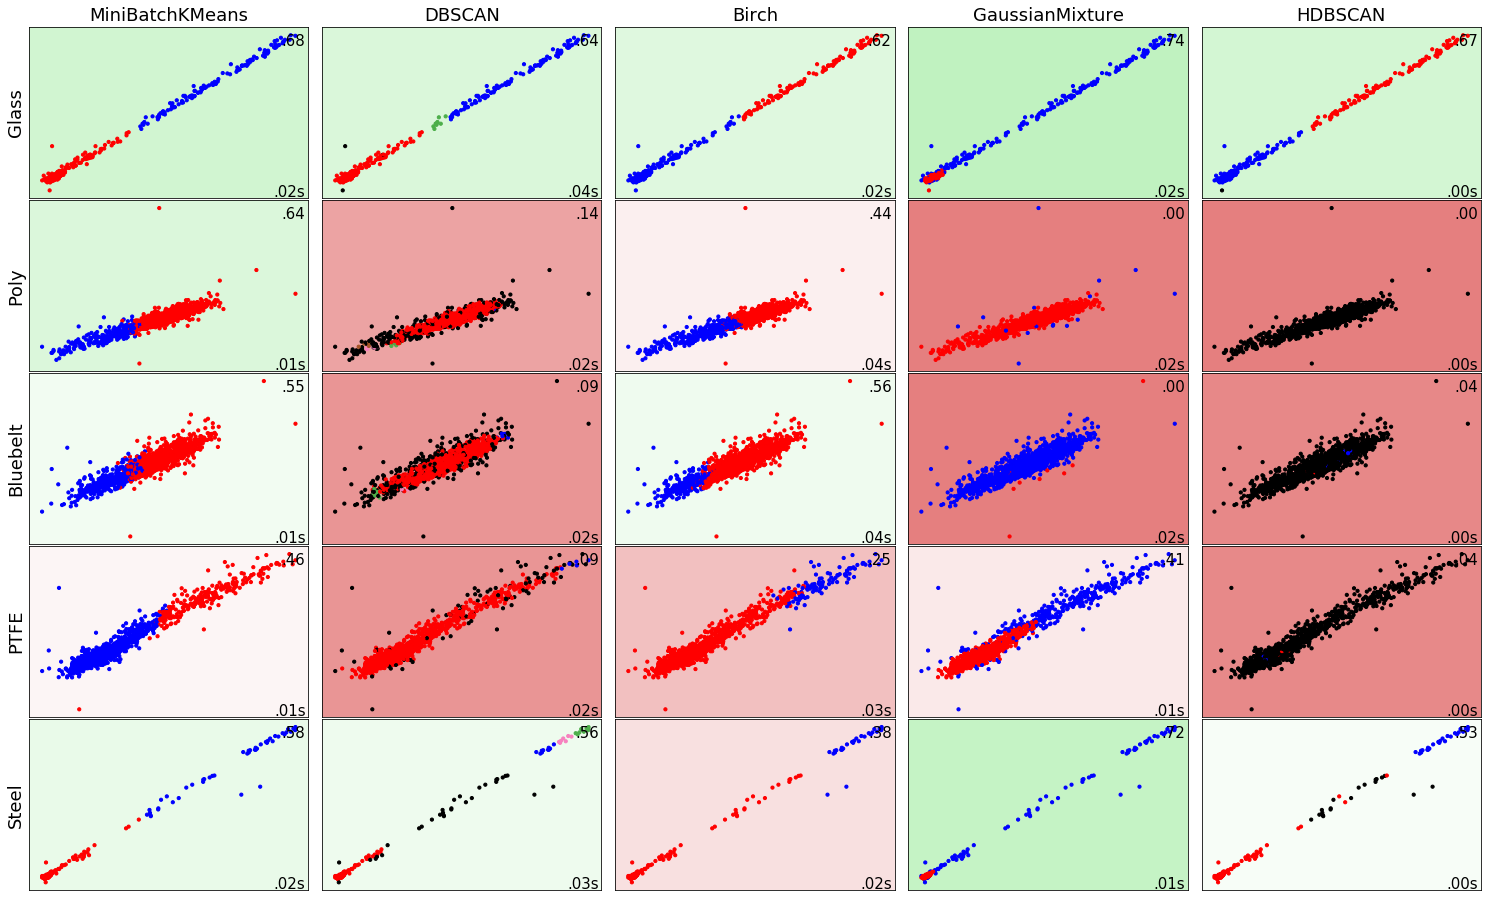

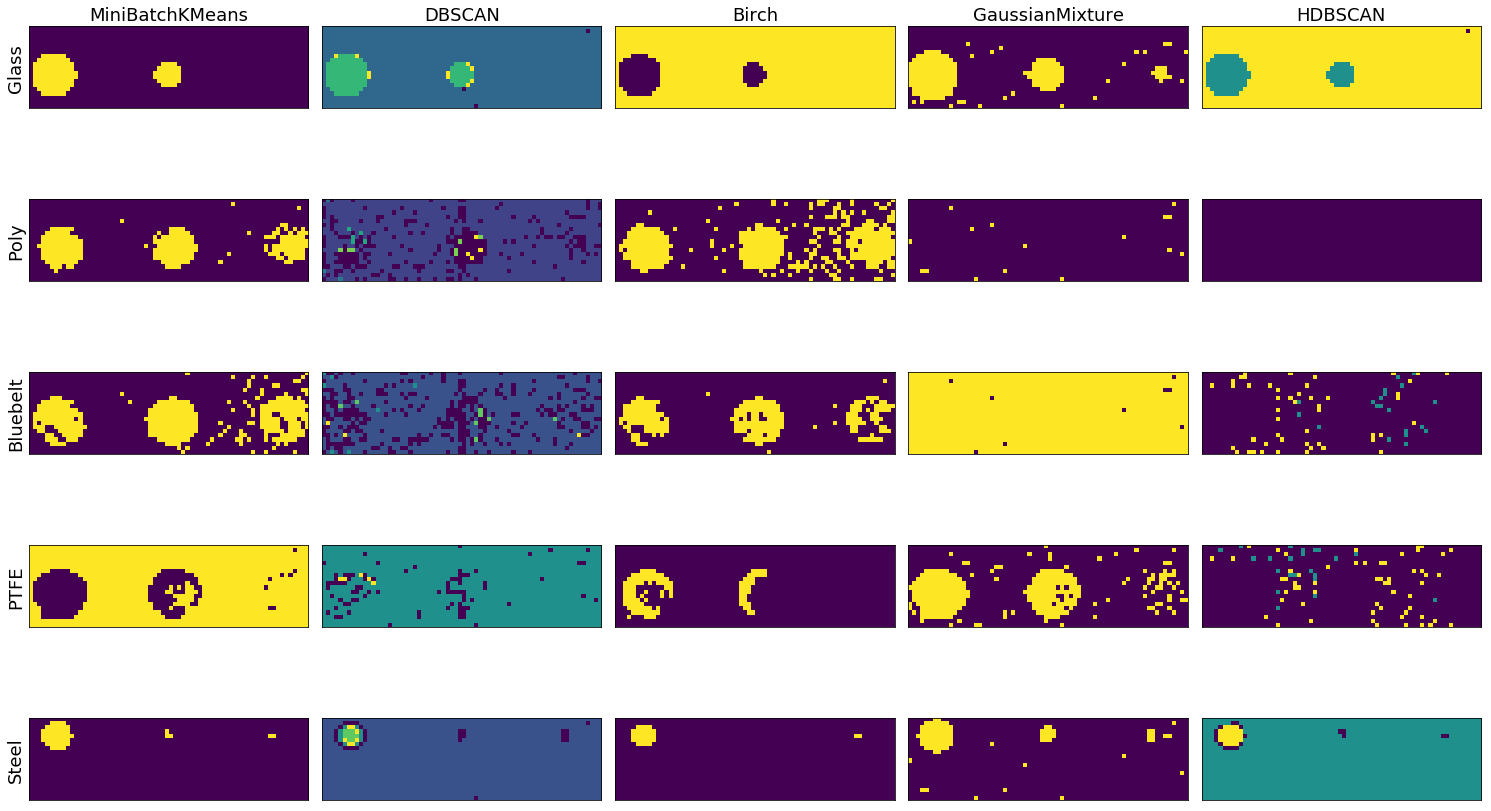

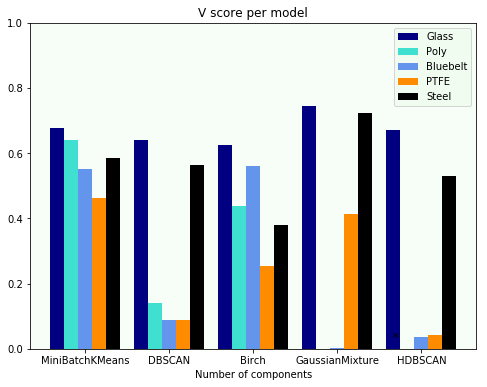

In [70]:
plot_results(1,1,1,mode='all',scale=True)

/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/jerichooconnell/anaconda3/lib/python3.5/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceW

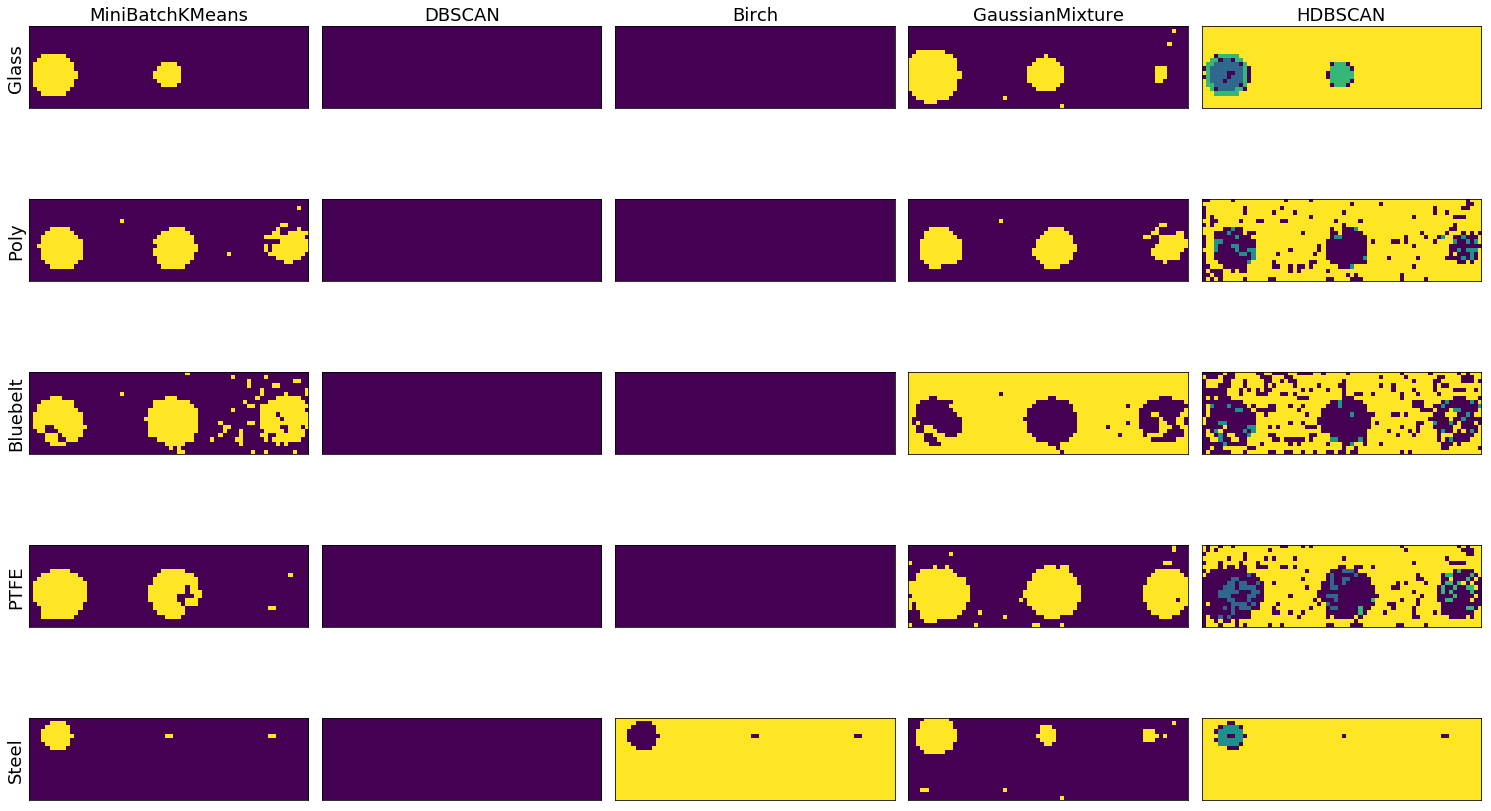

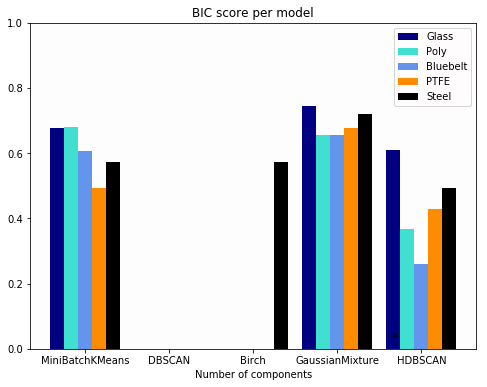

In [57]:
plot_results(0,1,1,mode=[])